In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from cnnlearning import *
from learningutils import *
from patchextraction import *
from imageprosessing import *
from nearest_neighbors import *
from evaluation import *
from classificationutils import *
from sharedvariables import *
from vesseldetection import *
from generate_datasets import *
from plotutils import no_ticks, plot_images_as_grid
from guitools import CvRoipolySelector, CvPointSelector

import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

import os
plt.rcParams['image.cmap'] = 'gray'

# Jupyter Notebook settings

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%autosave 20
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Imports for data analysis
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 2500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 2000)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# size=25
size=10
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

report_images_folder = os.path.join(
    '..', '..', 'thesis-report', 'images', 'channel_matching'
)
pathlib.Path(report_images_folder).mkdir(exist_ok=True, parents=False)

video_sessions = get_video_sessions(marked=True, validation=False)

[vs.load_vessel_masks() for vs in video_sessions]
[vs.basename for vs in video_sessions], 

Autosaving every 20 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(['Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA790nm_dewarped1_extract_reg_cropped',
  'Subject3_Session217_OS_(2,0)_1x1_988_OA790nm_dewarped1_extract_reg_cropped',
  'Subject47_Session375_OD_(0,-1)_1.04x1.04_3056_OA790nm1_extract_reg_cropped',
  'Subject48_Session379_OD_(-10,0)_1.04x1.04_3111_OA790nm1_extract_reg_cropped',
  'Subject48_Session379_OD_(-7,-2)_1.04x1.04_3107_OA790nm1_extract_reg_cropped',
  'Subject52_Session404_OD_(0,-3)_1.04x1.04_3466_OA790nm1_extract_reg_cropped',
  'Subject52_Session404_OD_(0,-4)_1.04x1.04_3465_OA790nm1_extract_reg_cropped',
  'Subject52_Session408_OD_(0,-5)_1.04x1.04_3576_OA790nm1_extract_reg_cropped'],)

In [2]:
class TemplateMatcher(object):
    def __init__(self, im1=None, im2=None, method=cv2.TM_CCOEFF_NORMED):
        template_matching_methods = [cv2.TM_CCOEFF, cv2.TM_CCOEFF_NORMED, cv2.TM_CCORR,
                                     cv2.TM_CCORR_NORMED, cv2.TM_SQDIFF,  cv2.TM_SQDIFF_NORMED]
        assert method in template_matching_methods
        
        self.method = method
        
        self.im1 = im1
        self.im2 = im2
        
        self.cx, self.cy = None, None
        self.dx, self.dy = None, None
        self.correlation_image = None
        self.image = None
        
        return
    
    def match(self):
        h, w = self.im1.shape
        centre_row, centre_col = int(h / 2), int(w / 2)
        template = self.im1[centre_row - 11:centre_row + 11,
                            centre_col - 11:centre_col + 11]
        self.template = template
        
        template = np.float32(self.template)
        
        image = np.float32(self.im2)
        im_h, im_w = image.shape
        template_h, template_w = template.shape
        
        correlation_image = cv2.matchTemplate(image, template, self.method)
        self.correlation_image = correlation_image
        
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(correlation_image)
        
        # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
        if self.method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc

        self.cx, self.cy  = (np.floor(top_left[0] + template_w / 2), np.floor(top_left[1] + template_h / 2))
        self.dx, self.dy = self.cx - (im_w - 1) / 2, self.cy - (im_h - 1) /2
        
        return self.cx, self.cy
    
    def visualize_matching(self, figsize=(15, 10), savename='', s=155,fontsize=10, linewidth=4.3):
        import matplotlib.patches
        from plotutils import savefig_tight
        
        im_h, im_w = self.im1.shape
        mid_x, mid_y = int((im_w - 1) / 2), int((im_h - 1) /2) 
        
        # template image
        _, axes = plt.subplots(1, 3, figsize=figsize)
        no_ticks(axes)
        axes[0].imshow(self.template)
        
        
        # image 1 with template square at middle
        axes[1].imshow(self.im1)
        if savename:
            savefig_tight(f'{savename}_template.png')
            
        rect = matplotlib.patches.Rectangle((mid_x - 11, mid_y -11) , 21, 21, linewidth=7.5, edgecolor='r', facecolor='none')
        axes[1].add_patch(rect)
        if savename:
            savefig_tight(f'{savename}_im1.png')
            
        # image 2 with displacement
        axes[2].imshow(self.im2)
        axes[2].scatter(mid_x, mid_y)
        assert [mid_x + self.dx, mid_y + self.dy] == [self.cx, self.cy]
        axes[2].scatter(self.cx, self.cy, s=s)

        axes[2].plot([mid_x,    self.cx],         [mid_y,    self.cy], 'b', linestyle='--', linewidth=linewidth, marker='', label='displacment')
        axes[2].plot([mid_x,    mid_x + self.dx], [mid_y,    mid_y],   'r', linestyle='--', linewidth=linewidth, marker='', label='dx')
        axes[2].plot([mid_x + self.dx,    mid_x + self.dx],           [mid_y,    mid_y + self.dy], 'y', linewidth=linewidth, linestyle='--', marker='', label='dy')
        axes[2].legend(prop={'size': fontsize})
        if savename:
            savefig_tight(f'{savename}_im2.png')
        
class FeatureMatcher(object):
    def __init__(self, im1, im2):
        self.im1 = im1
        self.im2 = im2
        
        im1_x, im1_y = None, None
        im2_x, im2_y = None, None
        self.dx, self.dy = None, None

    def match(self):
        im1 = self.im1
        im2 = self.im2
        
        if im1.dtype in [np.float, np.float16, np.float32, np.float64]:
            im1 = np.uint8(im1 * 255)
        
        if im2.dtype in [np.float, np.float16, np.float32, np.float64]:
            im2 = np.uint8(im2 * 255)
            
        for i in range(400, 0, -10):
            # Initiate feature detector
            surf = cv2.xfeatures2d.SURF_create(i)

            # find the keypoints and descriptors with surf
            kp1, des1 = surf.detectAndCompute(im1, None)
            kp2, des2 = surf.detectAndCompute(im2, None)

            if des1 is None or des2 is None or len(kp1) is 0 or len(kp2) is 0:
                continue

            # create BFMatcher object
            bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
            # Match descriptors.
            matches = bf.match(des1, des2)

            if len(matches) is 0:
                continue
            # Sort them in the order of their distance.
            matches = sorted(matches, key = lambda x:x.distance)
            # Draw first match
            match = matches[0]
            img1_idx = match.queryIdx
            img2_idx = match.trainIdx

            self.kp1 = kp1
            self.kp2 = kp2
            self.matches = matches
            
            # x - columns
            # y - rows
            # Get the coordinates
            self.im1_x, self.im1_y = kp1[img1_idx].pt
            self.im2_x, self.im2_y = kp2[img2_idx].pt
            
            self.dx, self.dy = self.im2_x -  self.im1_x, self.im2_y - self.im1_y
            return self.im2_x, self.im2_y
        
    def visualize_matching(self, figsize=(15, 10), linewidth=2.3, savefile=''):
        from plotutils import savefig_tight
        
        plt.figure(figsize=figsize)
        plt.subplot(121)
        plt.imshow(self.im1)
        no_ticks()
        plt.scatter(self.im1_x, self.im1_y)
        ax1 = plt.gca()
        
        plt.subplot(122)
        plt.imshow(self.im2)
        no_ticks()
        plt.scatter(self.im2_x, self.im2_y)
        ax2 = plt.gca()

        coordsA = "data"
        coordsB = "data"
        con = matplotlib.patches.ConnectionPatch(xyA=(self.im1_x, self.im1_y), xyB=(self.im2_x, self.im2_y), color='g',
                                                 coordsA=coordsA, coordsB=coordsB, mutation_scale=15, linewidth=3.5,
                                                 axesA=ax1, axesB=ax2, arrowstyle="->", shrinkB=5, shrinkA=5)
        ax2.add_artist(con)

        
        mid_x = self.im1_x
        mid_y = self.im1_y
        plt.plot([mid_x,    self.im2_x],         [mid_y,    self.im2_y], 'b', linestyle='--', linewidth=linewidth, marker='', label='displacment')
        plt.plot([mid_x,    mid_x + self.dx], [mid_y,    mid_y],   'r', linestyle='--', linewidth=linewidth, marker='', label='dx')
        plt.plot([mid_x + self.dx,    mid_x + self.dx],           [mid_y,    mid_y + self.dy], 'y', linewidth=linewidth, linestyle='--', marker='', label='dy')
        plt.legend()

        if savefile:
            savefig_tight(f'{savefile}_feature_matching.png')

In [3]:
def create_average_images(video_session,
                          frame_idx=0, 
                          mask=None,
                          patch_size=51,
                          sigma=1,
                          visualise=False,
                          savefile=''):
    from skimage.exposure import equalize_adapthist
    from imageprosessing import equalize_adapt_hist_masked
    from skimage.filters import gaussian
    
    vs = video_session
    if visualise:
        vs.load_vessel_masks()
        vs.visualize_registration()

    #### #### #### #### #### #### #### #### #### #### 
    from plotutils import savefig_tight
    
    # cv2.imshow(window, frame_OA790)
    registered_frame_oa850_clone = vs.registered_frames_oa850[frame_idx].copy()
    registered_frame_oa850_clone = registered_frame_oa850_clone[..., np.newaxis]
    registered_frame_oa850_clone = np.concatenate((registered_frame_oa850_clone, registered_frame_oa850_clone, registered_frame_oa850_clone), axis=-1)
    
    frame_oa790 = vs.frames_oa790[frame_idx]
    
    if mask is None:
        window = 'Please Select a straight Segment with a lot of positions'

        roipoly_selector = CvRoipolySelector(window, registered_frame_oa850_clone)
        roipoly_selector.activate()

        plt.rcParams['image.cmap'] = 'gray'
        plt.rcParams['axes.titlesize'] = 30
        plt.rcParams['figure.titlesize'] = 30

        plt.figure(figsize=(30, 20))
        plt.imshow(roipoly_selector.modified_image)
        if savefile:
            savefig_tight(f'{savefile}_selection.png')
    
        mask = roipoly_selector.mask.copy()
        
    if visualise:
        plt.figure(figsize=(30, 20))
        plt.subplot(121)
        plt.imshow(frame_oa790 * mask * vs.registered_mask_frames_oa850[frame_idx])
        no_ticks()
        plt.subplot(122)
        plt.imshow(vs.registered_frames_oa850[frame_idx] * mask * vs.registered_mask_frames_oa850[frame_idx])
        no_ticks()
        if savefile:
            savefig_tight(f'{savefile}_selected_segment.png')

    frame_oa790 = vs.frames_oa790[frame_idx]
    registered_frame_oa850 = vs.registered_frames_oa850[frame_idx]
    
    frame_cell_positions = vs.cell_positions[frame_idx]
    frame_cell_positions = np.delete(frame_cell_positions, np.where(~mask[frame_cell_positions[:, 1], frame_cell_positions[:, 0]])[0], axis=0)
    
    cell_patches_oa790 = extract_patches_at_positions(frame_oa790,            frame_cell_positions, mask=mask, patch_size=patch_size)
    cell_patches_oa850 = extract_patches_at_positions(registered_frame_oa850, frame_cell_positions, mask=mask, patch_size=patch_size)
    
    if sigma > 0:
        cell_patches_oa790 = cell_patches_oa790 / 255
        cell_patches_oa850 = cell_patches_oa850 / 255

        for i, (patch_790, patch_850) in enumerate(zip(cell_patches_oa790, cell_patches_oa850)):
            cell_patches_oa790[i] = gaussian(patch_790, sigma=sigma)
            cell_patches_oa850[i] = gaussian(patch_850, sigma=sigma)

        cell_patches_oa790 = np.uint8(cell_patches_oa790 * 255)
        cell_patches_oa850 = np.uint8(cell_patches_oa850 * 255)
    
    return cell_patches_oa790, cell_patches_oa850

# Select segment

In [4]:
vs = video_sessions[1]
vs.cell_positions[vs.validation_frame_idx]

registered_frame_oa850_clone = vs.registered_frames_oa850.mean(0)
registered_frame_oa850_clone = registered_frame_oa850_clone[..., np.newaxis]
registered_frame_oa850_clone = np.concatenate((registered_frame_oa850_clone, registered_frame_oa850_clone, registered_frame_oa850_clone), axis=-1)

window = 'Please Select a straight Segment with a lot of positions'
roipoly_selector = CvRoipolySelector(window, registered_frame_oa850_clone)
roipoly_selector.activate()

In [24]:
from imageprosessing import enhance_motion_contrast_de_castro, SessionPreprocessor
video_sessions = get_video_sessions(marked=True, validation=False)

vsp = SessionPreprocessor(vs)
vsp.preprocess_functions = [
    lambda frames: enhance_motion_contrast_de_castro(frames, sigma=.75),
    lambda frames: normalize_data(frames, (0,255)).astype(np.uint8),
    lambda frames: enhance_motion_contrast_j_tam(frames, sigma=.3),
    lambda frames: normalize_data(frames, (0, 255)).astype(np.uint8)
#     
]
vsp.apply_preprocessing_to_oa790()
vsp.apply_preprocessing_to_oa850()

[<function <lambda> at 0x0000020B162FDA60>, <function <lambda> at 0x0000020B1597D8C8>, <function <lambda> at 0x0000020B15D22C80>, <function <lambda> at 0x0000020B158DE400>]
hey
how
[<function <lambda> at 0x0000020B162FDA60>, <function <lambda> at 0x0000020B1597D8C8>, <function <lambda> at 0x0000020B15D22C80>, <function <lambda> at 0x0000020B158DE400>]
hey


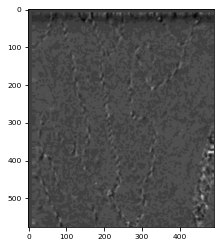

In [25]:
plt.imshow(vs.frames_oa790[0])

In [16]:
processed_frames[0].max()

1.361102520471485

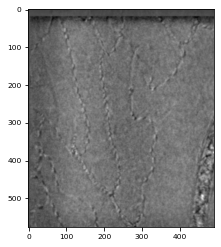

In [17]:
plt.imshow(normalize_data(processed_frames[0], (0, 255)))

In [12]:
vs.frames_oa790[0].max()

252

In [26]:
from skimage.filters import gaussian

dxs = {}
dys = {}
template_matchers = {}
feature_matchers = {}
for frame_idx in vs.cell_positions:
    template_matcher = TemplateMatcher()

    cell_patches_oa790, cell_patches_oa850 =\
    create_average_images(vs, 
                          frame_idx=frame_idx, 
                          mask=roipoly_selector.mask,
                          patch_size=51,
                          sigma=1)
    
    avg_cell_oa790 = np.mean(cell_patches_oa790, axis=0)
    avg_cell_oa850 = np.mean(cell_patches_oa850, axis=0)

    s=.0
    avg_cell_oa790 = avg_cell_oa790
    # avg_cell_oa850 = match_histograms(avg_cell_oa850, avg_cell_oa790)

    avg_cell_oa790 = gaussian(avg_cell_oa790, sigma=s)
    avg_cell_oa850 = gaussian(avg_cell_oa850, sigma=s)
    
    template_matcher.im1 = avg_cell_oa790
    template_matcher.im2 = avg_cell_oa850 
    template_matcher.match()
    
    feature_matcher = FeatureMatcher(avg_cell_oa790, avg_cell_oa850)
    feature_matcher.match()
    
    dxs[frame_idx] = template_matcher.dx
    dys[frame_idx] = template_matcher.dy
    template_matchers[frame_idx] = template_matcher
    feature_matchers[frame_idx] = feature_matcher

C:\Users\chadj\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


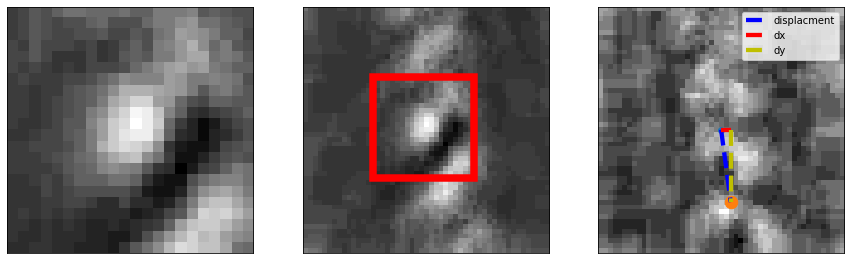

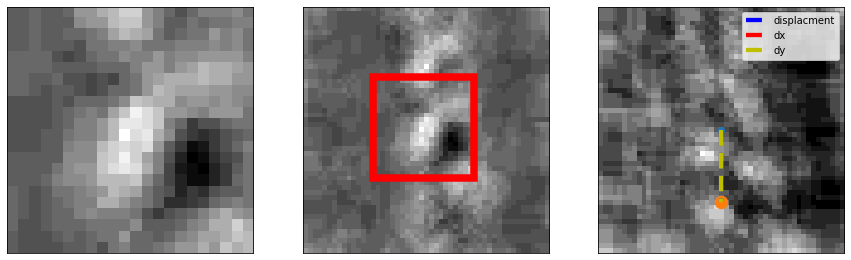

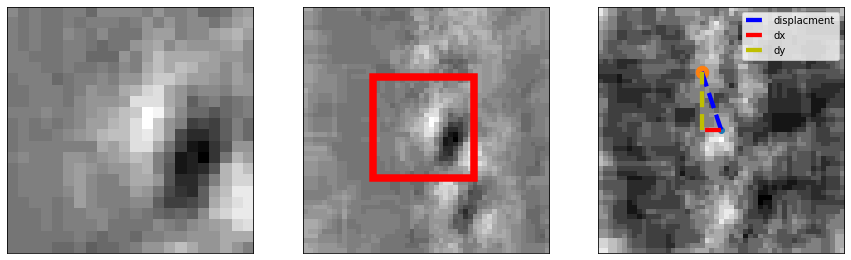

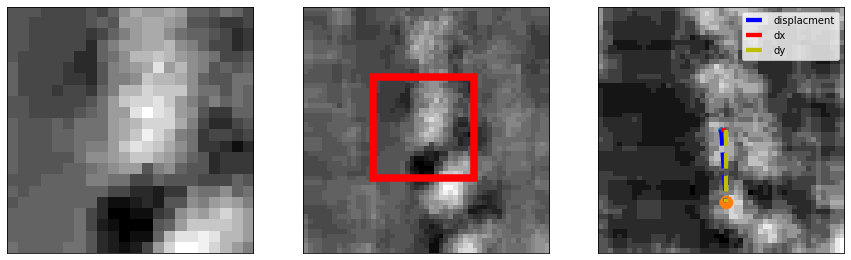

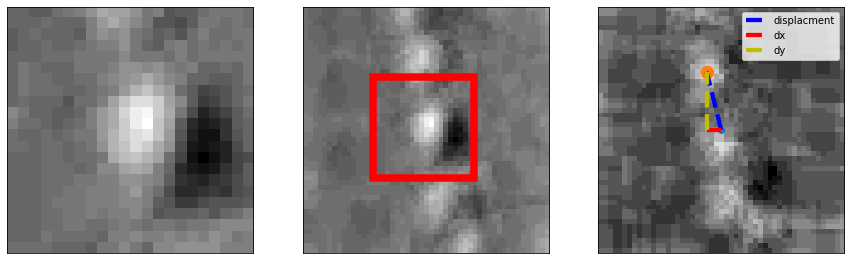

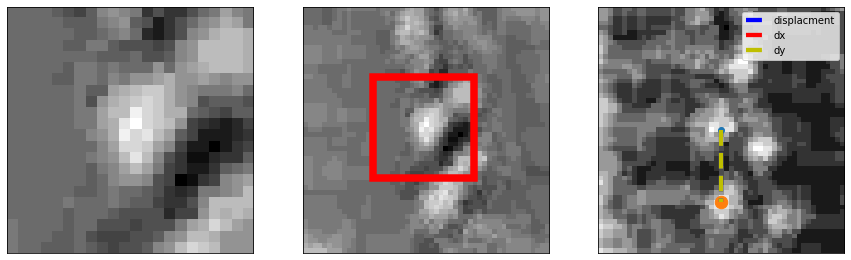

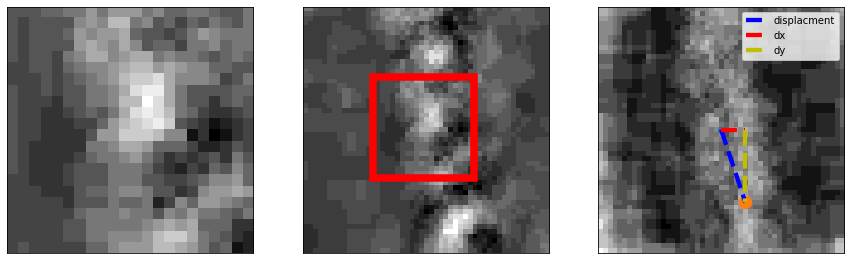

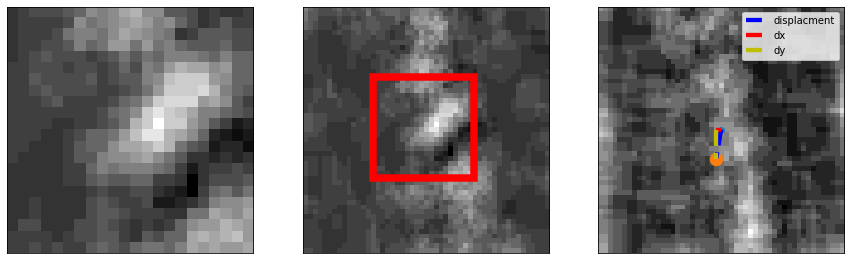

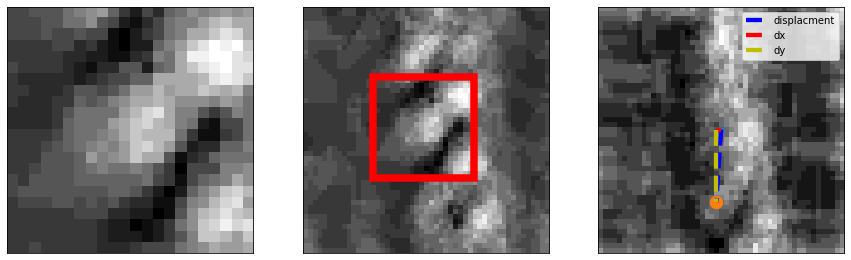

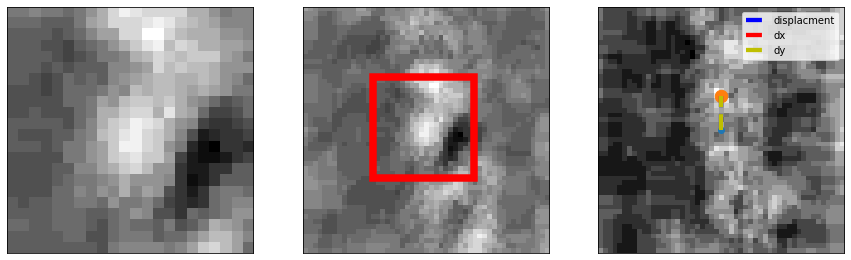

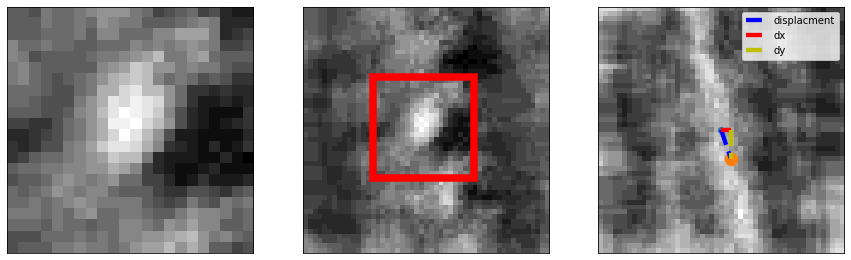

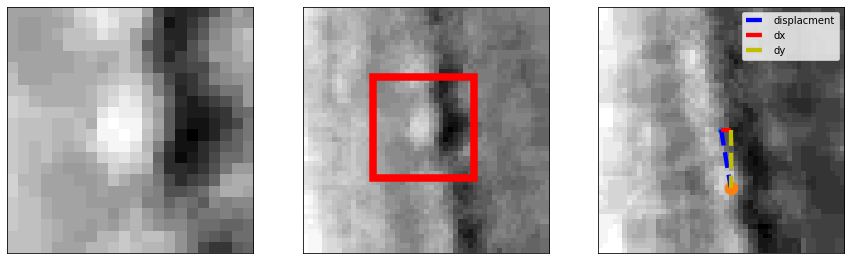

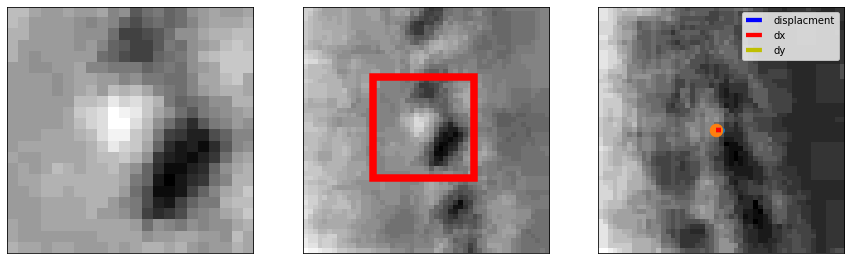

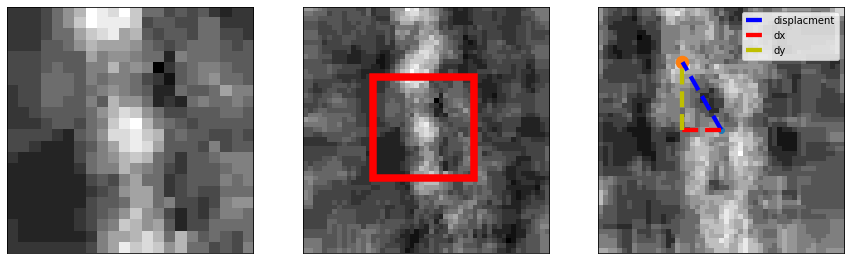

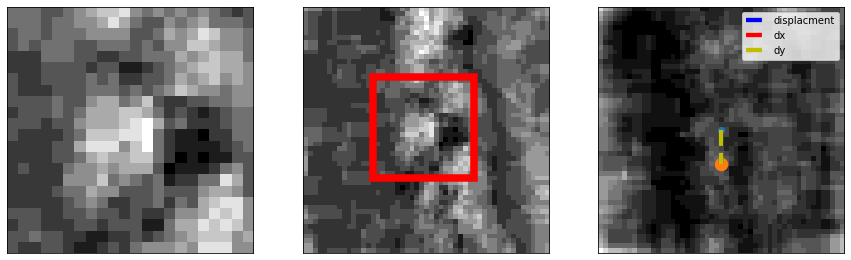

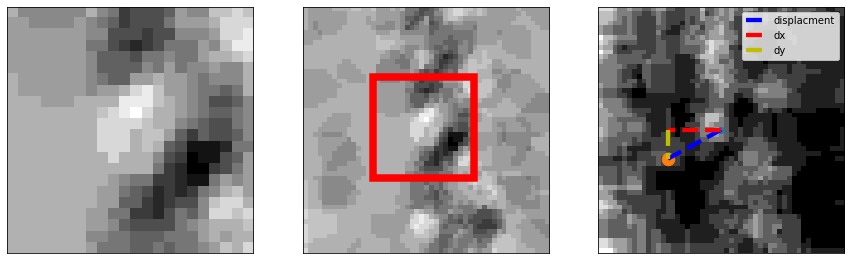

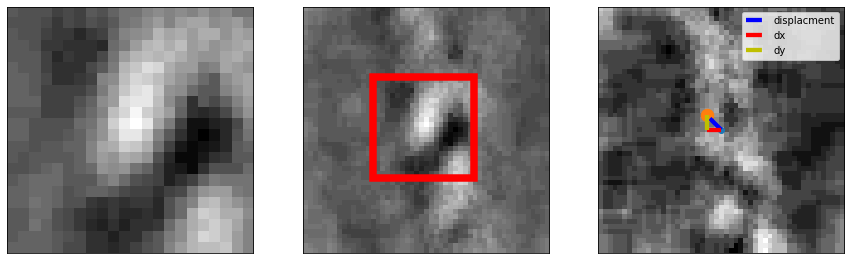

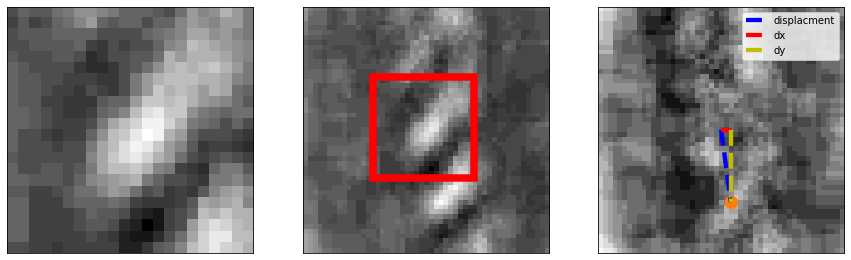

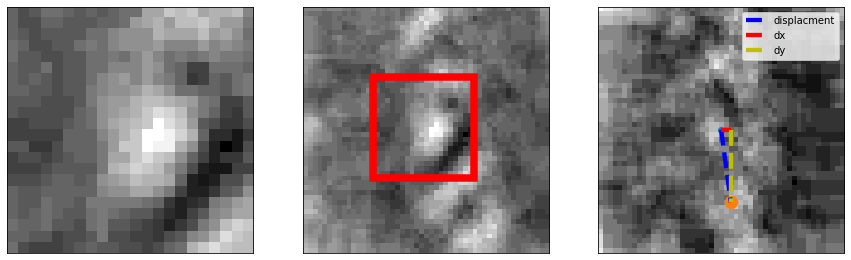

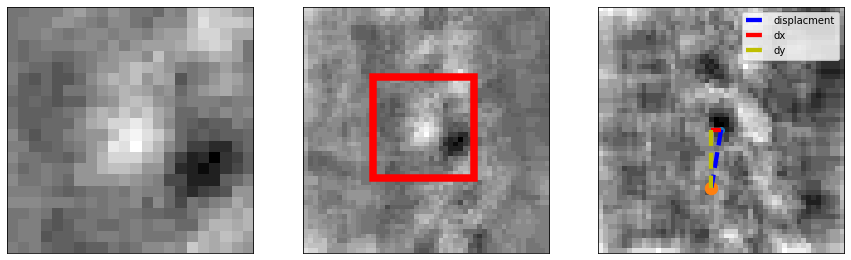

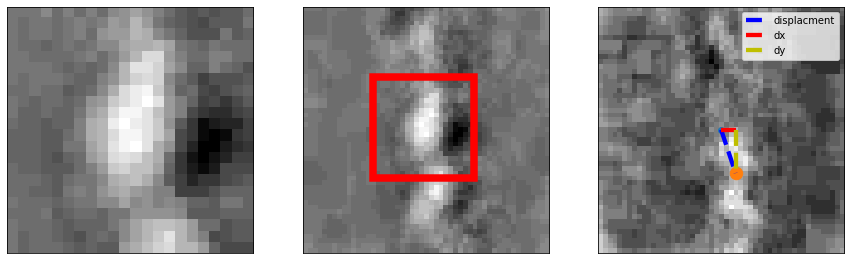

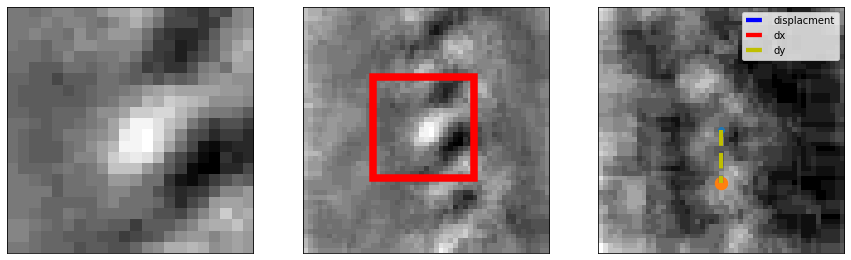

In [27]:
for frame_idx in template_matchers:
    template_matchers[frame_idx].visualize_matching()
#     feature_matchers[frame_idx].visualize_matching()

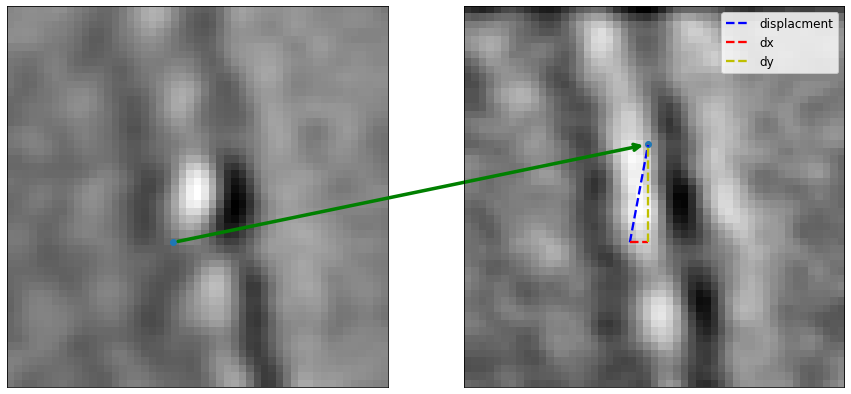

In [20]:
feature_matchers[0].visualize_matching()

(-1.0, -1.0, 1.4142135623730951, 24.0, 24.0)

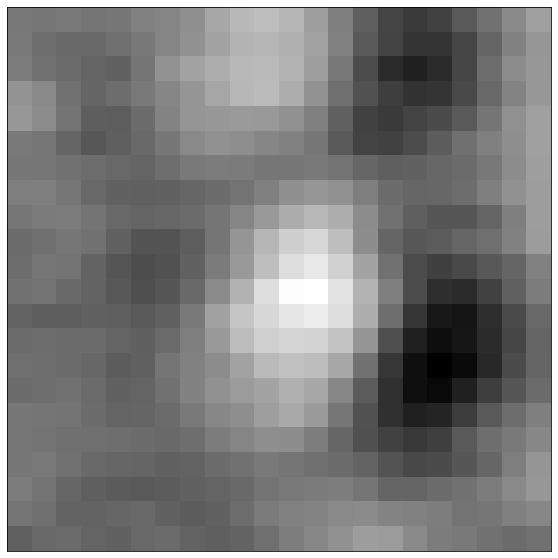

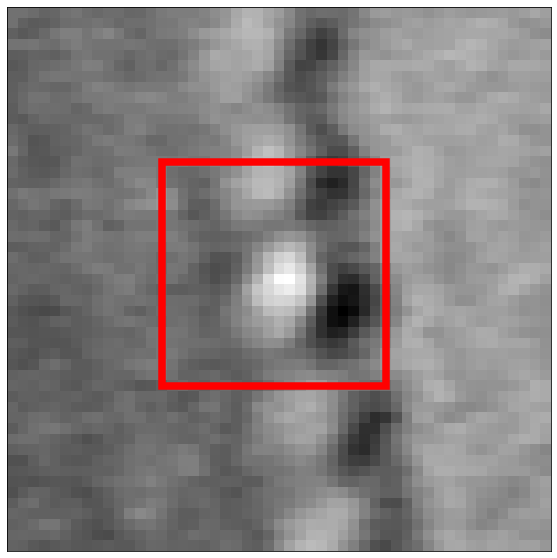

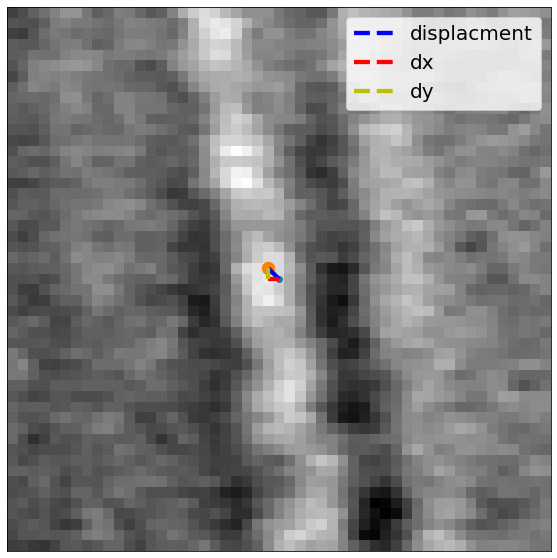

In [50]:
template_matcher = TemplateMatcher()
template_matcher.im1 = avg_cell_oa790
template_matcher.im2 = avg_cell_oa850
template_matcher.match()
template_matcher.visualize_matching()#savename=os.path.join(report_images_folder, f'{os.path.splitext(vs.basename)[0]}_avg_cell'))
template_matcher.dx, template_matcher.dy, np.sqrt(template_matcher.dx**2 + template_matcher.dy**2), template_matcher.cx, template_matcher.cy

(-1.5326595306396484,
 0.4382209777832031,
 1.5940774329466603,
 23.63005828857422,
 25.786205291748047,
 '..\\..\\thesis-report\\images\\channel_matching\\Subject3_Session217_OS_(2,0)_1x1_988_OA790nm_dewarped1_extract_reg_cropped_feature_matching.png')

<Figure size 1440x576 with 0 Axes>

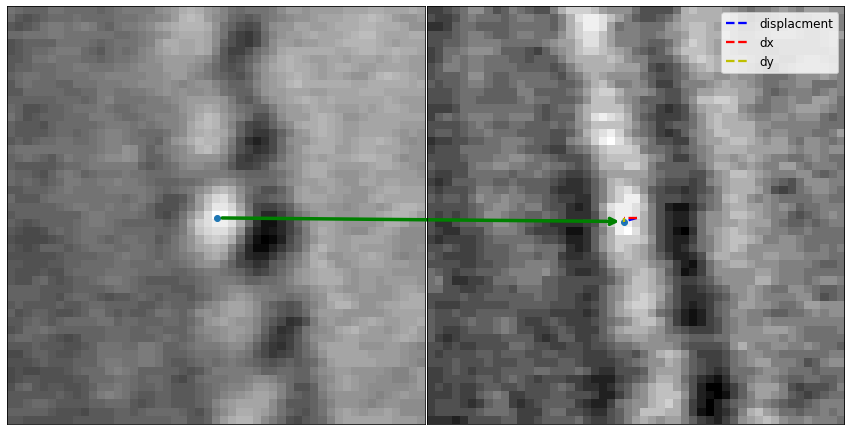

In [14]:
feature_matcher = FeatureMatcher(np.uint8(np.round(avg_cell_oa790)), np.uint8(np.round(avg_cell_oa850)))
feature_matcher.match()

plt.subplots_adjust(wspace=0.005, hspace=2)
feature_matcher.visualize_matching()
plt.subplots_adjust(wspace=0.005, hspace=2)

feature_matcher.dx, feature_matcher.dy, np.sqrt(feature_matcher.dx**2 + feature_matcher.dy**2), feature_matcher.im2_x, feature_matcher.im2_y, os.path.join(report_images_folder, f'{os.path.splitext(vs.basename)[0]}_feature_matching.png')